In [1]:
import sys, os, platform, random, glob
from tabulate import tabulate

path = os.path.abspath('./aux/')
if path not in sys.path:
    sys.path.append(path)

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt

from joblib import load

from aux import default_config as df_conf
from aux import func as sign
from aux import aux_fnc as ax

In [2]:
labeled_file = './aux/labels.csv'
all_labels = pd.read_csv(labeled_file,sep=',')

group_opts = ['Freesurfer','Manual','Pardoe']
dirs_all = []
labels_all = []
for group_opt in group_opts:
    str_add = ''
    if group_opt == 'Freesurfer':
        str_add = 'T1_'

    list_opt = all_labels.loc[(all_labels['Label'] == 2) & (all_labels['Group'] == group_opt)]
    dirs_all += ['{}{}/{}{:06.0f}/'.format(df_conf.DIR_BAS,group_opt.lower(),str_add,cod) for cod in list_opt.Subject]
    labels_all += list(list_opt.Label)
#dirs_all, labels_all = dirs_all[:60], labels_all[:60]
print('Found dirs:',len(dirs_all))

Found dirs: 79


Segmentations' vector:  (79, 50, 500)


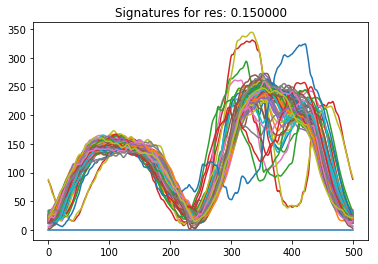

In [3]:
file2load = '{}parameters_refs.joblib'.format(df_conf.DIR_SAVE)
parms_refs = load(file2load) 
prof_ref = parms_refs['prof_ref']

resols = np.arange(df_conf.RESOLS_INF,df_conf.RESOLS_SUP,df_conf.RESOLS_STEP)
resols = np.insert(resols,0,df_conf.FIT_RES)
prof_vec = np.empty((len(dirs_all),resols.shape[0],df_conf.POINTS))

for ind, mask_path in enumerate(dirs_all):
    if ind > 0: #Fitting curves using the save one as basis
        pardoe_seg = glob.glob('{}*.corrected.cc.nii'.format(mask_path))
        if pardoe_seg != []:
            img_mask_msp = nib.load(pardoe_seg[0]).get_data()[::-1,::-1,0]
        else:
            file_mask_reg = '{}mask_reg'.format(mask_path)
            msp_points_reg = '{}msp_points_reg'.format(mask_path)

            in_img_msp = nib.load('{}.nii.gz'.format(msp_points_reg)).get_data()
            msp = np.argmax(np.sum(np.sum(in_img_msp,axis=-1),axis=-1))

            in_img_mask = nib.load('{}.nii.gz'.format(file_mask_reg)).get_data()
            img_mask_msp = in_img_mask[msp]

        refer_temp = sign.sign_extract(img_mask_msp, resols, df_conf.SMOOTHNESS, df_conf.POINTS)
        prof_vec[ind] = sign.sign_fit(prof_ref, refer_temp, df_conf.POINTS)

print("Segmentations' vector: ", prof_vec.shape)

plt.plot(prof_vec[:,df_conf.REG_EX].T)
plt.title('Signatures for res: %f'%(resols[df_conf.REG_EX]))
plt.show()

In [4]:
Y_test = np.array(labels_all)
X_test = prof_vec[:,1:,:] #Filtering the fitting resolution
resols = resols[1:] #Filtering the fitting resolution
resols_ref = np.arange(1,len(resols)+1)

val_norm = parms_refs['val_norm']
X_test_norm = X_test/val_norm

print('Test set: ', X_test_norm.shape, Y_test.shape)

Test set:  (79, 49, 500) (79,)


In [8]:
file2load = '{}arr_models_ind.joblib'.format(df_conf.DIR_SAVE)
d_train = load(file2load)
file2load = '{}ensemble_model.joblib'.format(df_conf.DIR_SAVE)
clf = load(file2load)
res_chs = parms_refs['res_chs']
print('=========================================================================')
print("Size ensemble:", len(res_chs), "Chosen resolutions:", resols_ref[res_chs])

svm_ind = np.array([]).reshape(0,Y_test.shape[0])
for res_ch in res_chs:
    svm_ind = np.vstack((svm_ind, d_train["string{0}".format(res_ch)].predict_proba(X_test_norm[:,res_ch,:])[:,1]))
svm_ind = svm_ind.T

y_true = Y_test>0

y_pred_probs = clf.predict_proba(svm_ind)[:,1]

Size ensemble: 11 Chosen resolutions: [17 30 48 26 34 28 47  1 43  2 40]


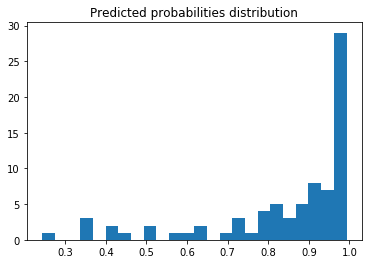

In [9]:
plt.hist(y_pred_probs,bins=24)
plt.title('Predicted probabilities distribution')
plt.show()

Size ensemble: 11 Chosen resolutions: [17 30 48 26 34 28 47  1 43  2 40]
------------------------------------
ROC Curve Teste:


/home/wilomaku/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/wilomaku/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


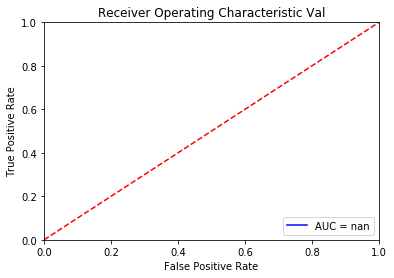

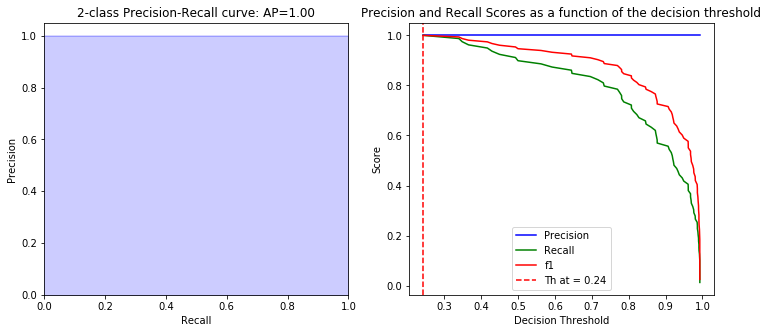

NameError: name 'confusion_matrix' is not defined

In [7]:
AUC_cl = ax.plot_roc(y_true, y_pred_probs)
__, opt_th = ax.plot_prc(y_true, y_pred_probs)

y_pred = y_pred_probs > opt_th

mx_conf = confusion_matrix(y_true, y_pred)
ax.plot_matrix(mx_conf, classes=np.unique(y_true), fig_size=4,
            title='Confussion matrix', opt_bar=False)

ind_err_rand = np.where(np.logical_xor(y_true, y_pred))
ind_err = test_index[ind_err_rand]

accuracy, recall, precision, f1 = ax.report_metrics(mx_conf)

print('===== Final Report =====')
print(tabulate([['AUC', AUC_cl],
                ['Accuracy', accuracy],
                ['Recall', recall],
                ['Precision', precision],
                ['F1', f1],],
               ['Metric', 'Value'], tablefmt='grid'))